# Initial Setup

In [1]:
import sys
!git clone https://github.com/a3i-2022-2023/04-rul
sys.path.append("/kaggle/working/04-rul")

Cloning into '04-rul'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 69 (delta 8), reused 66 (delta 5), pack-reused 0
Unpacking objects: 100% (69/69), 16.95 MiB | 6.20 MiB/s, done.


In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
import re
import matplotlib.pyplot as plt
import numpy as np
import notebooks.util.util as util

# Objectives

Given the top x games and their trand, we aim at:

- Predicting their trend in the near future in order to evaluate their "remaining useful life", predicting when interest may begin to fade, in order to forecast when to release update
- Fill missing values in order to complete a trend

# Dataset Analysis

In [3]:
# Get the dataset
df = pd.read_csv("/kaggle/input/game-data/Twitch_game_data.csv", encoding='cp1252')

The Dataset has:

- **Rank**

    For each month the ranking of the top 200 games
   
- **Game**

    The name of the videogame
    
- **Month**

    Int representing the month
   
- **Year**

     Int representing the year
     
- **Hours_watched**

    ??
   
- **Hours_Streamed**

    Total number of hours collectively streamed by all the channels that streamed that game 
    
- **Peak_viewers**

    Maximum number of viewers at one time that watched that game
   
- **Peak_channels**

     Maximum number of channels at one time that streamed that game
     
- **Streamers**

    Number of total streamers that streamed that game
   
- **Avg_viewers**

    ??
    
- **Avg_channels**

    ??
   
- **Avg_viewer_ratio**

    ??
    
     

In [7]:
# Quick glance at its structure
df

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044 hours,530270,2903,129172,127021,1833,69.29
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105 hours,372654,2197,120849,64378,1117,57.62
2,3,Dota 2,1,2016,45185893,433397 hours,315083,1100,44074,60815,583,104.26
3,4,Hearthstone,1,2016,39936159,235903 hours,131357,517,36170,53749,317,169.29
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578 hours,71639,3620,214054,21740,1549,14.03
...,...,...,...,...,...,...,...,...,...,...,...,...
16795,196,SCUM,12,2022,608613(68.5%),47458(64.7%),26987(320.9%),151(18.9%),3591(41.5%),819(63.1%),63(57.5%),12.82(2.3%)
16796,197,Dungeon Fighter Online,12,2022,606520(7.9%),17372(14.3%),5243(-85.2%),70(-13.6%),742(25.5%),816(4.3%),23(9.5%),34.91(-5.6%)
16797,198,Detroit: Become Human,12,2022,600990(49.6%),21395(10.0%),23681(158.1%),92(35.3%),5198(9.0%),808(44.8%),28(3.7%),28.09(36.0%)
16798,199,Super People,12,2022,597551(-53.5%),29116(-57.1%),23584(38.7%),124(-51.2%),3432(-51.8%),804(-55.0%),39(-58.5%),20.52(8.3%)


In [16]:
print("The dataset has", df.shape[0], "rows")

The dataset has 16800 rows


Immediately it's noticeable that:

- Month and Year can be merged in one single value Date which encapsulate the same concepte 
- Hours_Streamed is a string since it has the adjective hourse in its values, we have to clean this column and convert it to Int values to use it correctly
- Hours_watched, Hours_Streamed, Peak_viewers, Peak_channels, Streamers, Avg_viewers, Avg_channels and Avg_viewer_ratio all change format at one point in time, including also a percentage (which represent????). We have to format each of these column to their single Int value to use them correctly

But let's analyze a bit more our data

In [8]:
df.describe()

,Rank,Month,Year
count,16800.000000,16800.000000,16800.00000
mean,100.500000,6.500000,2019.00000
std,57.736024,3.452155,2.00006
min,1.000000,1.000000,2016.00000
25%,50.750000,3.750000,2017.00000
50%,100.500000,6.500000,2019.00000
75%,150.250000,9.250000,2021.00000
max,200.000000,12.000000,2022.00000


In [9]:
df.dtypes

Rank                 int64
Game                object
Month                int64
Year                 int64
Hours_watched       object
Hours_Streamed      object
Peak_viewers        object
Peak_channels       object
Streamers           object
Avg_viewers         object
Avg_channels        object
Avg_viewer_ratio    object
dtype: object

In [26]:
print("Number of unique games in the dataset:",len(list(df["Game"].unique())))

Number of unique games in the dataset: 1990


# Dataset cleaning

## Clean and change format of each object column with values

In [17]:
# Get the number in the string
def getNumber(x):
    return int(re.match("\d+", x).group())

In [18]:
columns_to_convert = ['Hours_watched', 'Hours_Streamed', 'Peak_viewers', 'Peak_channels', 'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio']

In [19]:
for column_name in columns_to_convert:
    df[column_name] = df[column_name].map(lambda x: getNumber(x))

In [20]:
df

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,1,League of Legends,1,2016,94377226,1362044,530270,2903,129172,127021,1833,69
1,2,Counter-Strike: Global Offensive,1,2016,47832863,830105,372654,2197,120849,64378,1117,57
2,3,Dota 2,1,2016,45185893,433397,315083,1100,44074,60815,583,104
3,4,Hearthstone,1,2016,39936159,235903,131357,517,36170,53749,317,169
4,5,Call of Duty: Black Ops III,1,2016,16153057,1151578,71639,3620,214054,21740,1549,14
...,...,...,...,...,...,...,...,...,...,...,...,...
16795,196,SCUM,12,2022,608613,47458,26987,151,3591,819,63,12
16796,197,Dungeon Fighter Online,12,2022,606520,17372,5243,70,742,816,23,34
16797,198,Detroit: Become Human,12,2022,600990,21395,23681,92,5198,808,28,28
16798,199,Super People,12,2022,597551,29116,23584,124,3432,804,39,20


In [21]:
df.dtypes

Rank                 int64
Game                object
Month                int64
Year                 int64
Hours_watched        int64
Hours_Streamed       int64
Peak_viewers         int64
Peak_channels        int64
Streamers            int64
Avg_viewers          int64
Avg_channels         int64
Avg_viewer_ratio     int64
dtype: object

## Check for NaN values in the dataset

In [22]:
df.isnull().sum()

Rank                0
Game                1
Month               0
Year                0
Hours_watched       0
Hours_Streamed      0
Peak_viewers        0
Peak_channels       0
Streamers           0
Avg_viewers         0
Avg_channels        0
Avg_viewer_ratio    0
dtype: int64

In [19]:
df[df['Game'].isna()]

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
7561,162,NaN,2,2019,317951,77004,30919,5804,21758,473,114,4


Since there is only one game name with it's name missing, we can't draw any conclusion on what game it might be, so we decided to drop it.

(can we do something with it?)

In [20]:
df = df.dropna()

In [21]:
df[df['Game'].isna()]

,Rank,Game,Month,Year,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio


## Merge Month and Year in Date

In [33]:
# Create merged unique date representation
df['Date'] = df.apply(lambda row: pd.to_datetime(str(row['Month']) + str(row['Year']),format='%m%Y'), axis=1)
del df['Month']
del df['Year']

In [ ]:
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                      ):
#     print(len(tmp))
# 
#lol, Counter-Strike: Global Offensive, Hearthstone, 

## Check for duplicates

In [34]:
duplicates = df[df.duplicated()]
duplicates 

,Rank,Game,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Date


We do not have any duplicates, but this information alone is not very useful.

Since we have a lot of different values, an exact copy of a row was very unlikely, and fortunately we did not have any row duplicates.

But we still could have duplicates of the same game in the same date but with differen measurements, due to some mistake in the data gathering process.

In [35]:
duplicates = df[df[['Game','Date']].duplicated(keep=False)]
duplicates 

,Rank,Game,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio,Date
1915,116,Resident Evil,251183,3976,9871,21,7420,338,5,63,2016-10-01
1979,180,Resident Evil,143542,4113,9577,31,1047,193,5,34,2016-10-01
6474,75,Dungeons & Dragons,790966,21961,38597,181,2876,1100,30,36,2018-09-01
6502,103,Dungeons & Dragons,550645,10198,40261,127,2091,765,14,54,2018-09-01
7212,13,Resident Evil 2,16394917,449333,314244,6488,70644,22065,604,36,2019-01-01
7214,15,Atlas,12110031,187032,69614,637,10070,16298,251,64,2019-01-01
7249,50,Atlas,2106560,23485,75774,728,3909,2835,31,89,2019-01-01
7329,130,Resident Evil 2,578746,16569,38429,285,5441,778,22,34,2019-01-01
13671,72,Retro,2976840,131077,20554,424,8577,4140,182,22,2021-09-01
13719,120,Retro,1511016,56192,23532,329,6430,2101,78,26,2021-09-01


As we can see, due to some mistake, some games were introduced with different values but in the same date.
We can:
- Drop both values (this)
- Average of the values
- ???

In [37]:
df_no_duplicates = df.drop_duplicates(subset=['Game', 'Date'],keep=False)

In [38]:
print("We removed a total of", df.shape[0]- df_no_duplicates.shape[0], "duplicate rows")

We removed a total of 14 duplicate rows


# Create a subset of the most streamed games in the whole dataset

To obtain the most streamed games in our whole dataset we used a threshold which limits the games that were present more than 70 times.

Since our dataset is focused on the month starting from 2016 to 2022, we will have a total of 84 maximum times a game can be present in our dataset (12 month * 7 years).

In [39]:
# List of top streamed games "ever"
always_on_top = []

# Threshold which represent the times a game is present in the dataset
value_threshold = 70

In [40]:
# Get the top games
for name in list(df_no_duplicates["Game"].unique()):
    if(len(df_no_duplicates[df_no_duplicates['Game'] == name]) >= value_threshold):
        always_on_top.append(name)

In [43]:
print("A total of", len(always_on_top), "games were present at least", value_threshold, "times")

A total of 59 games were present at least 70 times


In [45]:
always_on_top

['League of Legends',
 'Counter-Strike: Global Offensive',
 'Dota 2',
 'Hearthstone',
 'Minecraft',
 'World of Warcraft',
 'Talk Shows & Podcasts',
 'StarCraft II',
 'Diablo III',
 'World of Tanks',
 "Tom Clancy's Rainbow Six Siege",
 'RuneScape',
 'Grand Theft Auto V',
 'SMITE',
 'Poker',
 'Heroes of the Storm',
 'DayZ',
 'Magic: The Gathering',
 'Super Smash Bros. Melee',
 'Music',
 'Path of Exile',
 'Rocket League',
 'The Legend of Zelda: Ocarina of Time',
 'Rust',
 'Bloodborne',
 'The Elder Scrolls V: Skyrim',
 'Dark Souls',
 'Euro Truck Simulator 2',
 'Super Mario 64',
 'osu!',
 'Warcraft III',
 'Warframe',
 'World of Warships',
 'Guild Wars 2',
 'Dungeons & Dragons',
 'Street Fighter V',
 'The Witcher 3: Wild Hunt',
 'Tibia',
 'The Elder Scrolls Online',
 'MapleStory',
 'Black Desert Online',
 'The Sims 4',
 'Summoners War: Sky Arena',
 '7 Days to Die',
 'Terraria',
 'Star Citizen',
 'Overwatch',
 'Stardew Valley',
 'Games + Demos',
 'Retro',
 'Age of Empires II',
 'Roblox',
 'Da

Now we can create the subset of our dataset

In [44]:
df_reduced = df_no_duplicates[df_no_duplicates['Game'].isin(always_on_top)].copy()

In [36]:
# games_dict = {}
# df_allDates = pd.DataFrame(pd.date_range(df_reduced["Date"].min(), df_reduced["Date"].max(), freq='MS'), columns =['Date'])
# for game in df_reduced['Game'].unique():
#     df_allDates = pd.DataFrame(pd.date_range(df_reduced["Date"].min(), df_reduced["Date"].max(), freq='MS'), columns =['Date'])
#     df_temp = 

Since we want a continuous dataset that has all the month for each game in all the analyez years, we need to modify the our subset inserting NaN values in case a game was not present in that month.

In [46]:
df_allDates = pd.DataFrame(pd.date_range(df_reduced["Date"].min(), df_reduced["Date"].max(), freq='MS'), columns =['Date'])
df_names = pd.DataFrame(df_reduced['Game'].unique(), columns = ['Game'])
df_names = df_names.merge(df_allDates, how='cross')
df_clean = df_names.merge(df_reduced, how="left")
df_clean

,Game,Date,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,League of Legends,2016-01-01,1.0,94377226.0,1362044.0,530270.0,2903.0,129172.0,127021.0,1833.0,69.0
1,League of Legends,2016-02-01,1.0,93154772.0,1266715.0,475784.0,2712.0,117996.0,134035.0,1822.0,73.0
2,League of Legends,2016-03-01,1.0,94514511.0,1264029.0,599114.0,2585.0,117734.0,127206.0,1701.0,74.0
3,League of Legends,2016-04-01,1.0,88389049.0,1217250.0,553165.0,2945.0,113251.0,122933.0,1692.0,72.0
4,League of Legends,2016-05-01,1.0,80679320.0,1196096.0,433005.0,2635.0,118593.0,108585.0,1609.0,67.0
...,...,...,...,...,...,...,...,...,...,...,...
4951,The Legend of Zelda: Breath of the Wild,2022-08-01,174.0,842067.0,41103.0,12964.0,129.0,5129.0,1133.0,55.0,20.0
4952,The Legend of Zelda: Breath of the Wild,2022-09-01,133.0,1275236.0,44913.0,24594.0,144.0,5806.0,1773.0,62.0,28.0
4953,The Legend of Zelda: Breath of the Wild,2022-10-01,112.0,1454512.0,42197.0,23038.0,114.0,5165.0,1957.0,56.0,34.0
4954,The Legend of Zelda: Breath of the Wild,2022-11-01,161.0,777486.0,37033.0,22466.0,112.0,4646.0,1081.0,51.0,20.0


In [47]:
df_clean['Rank'].isna().sum()

204

We can see that we correctly managed to insert NaN columns.

In [50]:
print("Example of an inserted row:\n")
df_clean.iloc[84]

Example of an inserted row:



Game                  Age of Empires II
Date                2016-01-01 00:00:00
Rank                                NaN
Hours_watched                       NaN
Hours_Streamed                      NaN
Peak_viewers                        NaN
Peak_channels                       NaN
Streamers                           NaN
Avg_viewers                         NaN
Avg_channels                        NaN
Avg_viewer_ratio                    NaN
Name: 84, dtype: object

Now we can sort the dataset.

In [51]:
# Sort by game and then by date (ty garfield)
df_clean = df_clean.sort_values(by=['Game', 'Date'], ascending=True).reset_index(drop=True)
df_clean

,Game,Date,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
0,7 Days to Die,2016-01-01,129.0,269681.0,12131.0,4405.0,44.0,1240.0,362.0,16.0,22.0
1,7 Days to Die,2016-02-01,159.0,139365.0,8921.0,3812.0,34.0,887.0,200.0,12.0,15.0
2,7 Days to Die,2016-03-01,192.0,99191.0,8504.0,4817.0,58.0,932.0,133.0,11.0,11.0
3,7 Days to Die,2016-04-01,117.0,212199.0,15614.0,3993.0,52.0,1439.0,295.0,21.0,13.0
4,7 Days to Die,2016-05-01,116.0,195722.0,11696.0,4507.0,44.0,1245.0,263.0,15.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
4951,osu!,2022-08-01,135.0,1284056.0,141408.0,61709.0,309.0,33100.0,1728.0,190.0,9.0
4952,osu!,2022-09-01,142.0,1088813.0,128845.0,13521.0,327.0,29866.0,1514.0,179.0,8.0
4953,osu!,2022-10-01,132.0,1243022.0,128051.0,12886.0,306.0,28711.0,1672.0,172.0,9.0
4954,osu!,2022-11-01,118.0,1203154.0,117160.0,19081.0,307.0,27088.0,1673.0,162.0,10.0


In [61]:
def plot_series(df, feature_name:str, figsize=(20,8), show_sample_range=False, show_missing_range=False, show_sample_points=False):
    # Plot feature_name trend
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(df['Date'].unique(), df[feature_name], color="blue", label = feature_name)
    
    if show_sample_range:
        line_points = df[feature_name].where(df[feature_name].isna(), 0)
        ax.plot(df['Date'].unique(), line_points, color="forestgreen")
    
    if show_missing_range:
        line_points = df[feature_name].where(df[feature_name].isna(), 0)
        not_line_points = line_points.apply(lambda x: np.NaN if not np.isnan(x) else 0)
        ax.scatter(df['Date'].unique(), not_line_points, color="r")
        
    if show_sample_points:
        ax.scatter(df['Date'].unique(), df[feature_name], color="purple", marker='x')
        
    plt.plot()
    

In [147]:
np.NaN == np.NaN # Da tenere perchè si.

False

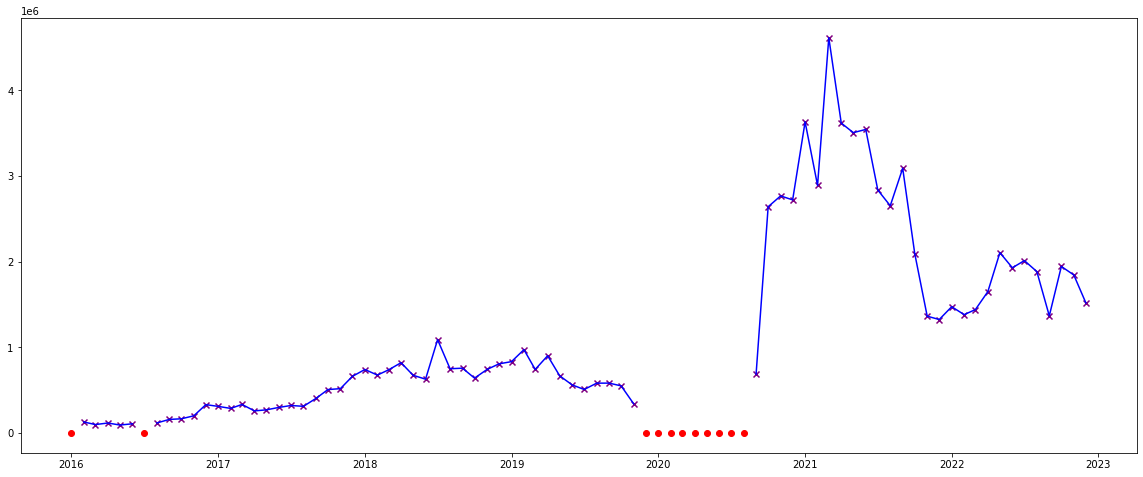

In [62]:
tmp = df_clean[df_clean['Game'] == "Age of Empires II"]
plot_series(df=tmp, feature_name="Hours_watched", show_missing_range = True, show_sample_points=True)

In [39]:
df_reduced.corr()

,Rank,Hours_watched,Hours_Streamed,Peak_viewers,Peak_channels,Streamers,Avg_viewers,Avg_channels,Avg_viewer_ratio
Rank,1.000000,-0.447249,-0.453997,-0.391788,-0.437320,-0.428778,-0.447407,-0.453926,-0.415471
Hours_watched,-0.447249,1.000000,0.868251,0.789473,0.771095,0.729151,0.999554,0.867864,0.271514
Hours_Streamed,-0.453997,0.868251,1.000000,0.694765,0.903436,0.906582,0.868211,0.999501,0.012864
Peak_viewers,-0.391788,0.789473,0.694765,1.000000,0.641658,0.652072,0.788438,0.694294,0.250168
Peak_channels,-0.437320,0.771095,0.903436,0.641658,1.000000,0.805404,0.771453,0.903529,0.012787
Streamers,-0.428778,0.729151,0.906582,0.652072,0.805404,1.000000,0.729524,0.906546,-0.036218
Avg_viewers,-0.447407,0.999554,0.868211,0.788438,0.771453,0.729524,1.000000,0.868669,0.271367
Avg_channels,-0.453926,0.867864,0.999501,0.694294,0.903529,0.906546,0.868669,1.000000,0.012924
Avg_viewer_ratio,-0.415471,0.271514,0.012864,0.250168,0.012787,-0.036218,0.271367,0.012924,1.000000
